<span style="font-size:24px; font-weight:bold; color:black;">Step 1: Data Loading & Exploratory Data Analysis  </span>

In [1]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans

In [3]:
# Load the dataset
df = pd.read_csv("marcketing.csv")

In [5]:
# Exploratory Data Analysis (EDA)
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
print(df.describe())

# Handle Missing Values
# Fill missing values in numerical columns with the median
df.fillna(df.median(numeric_only=True), inplace=True)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    224

<span style="font-size:20px; font-weight:bold; color:black;">Step 1.1: Income Distribution </span>

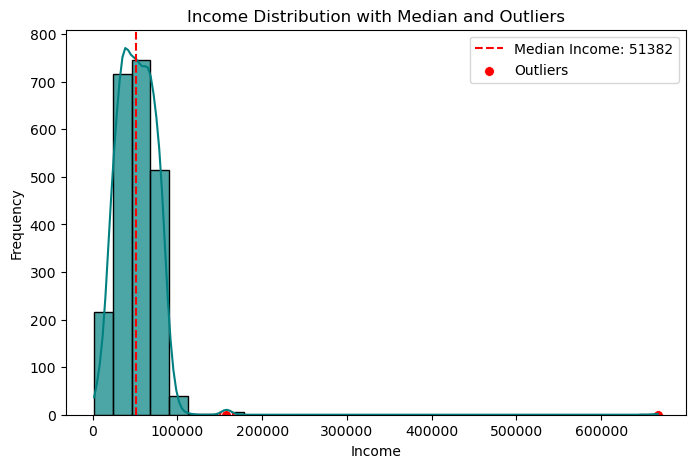

In [7]:
# Calculate median income
median_income = df["Income"].median()

# Plot histogram with KDE
plt.figure(figsize=(8, 5))
sns.histplot(df["Income"], bins=30, kde=True, color="teal", alpha=0.7, edgecolor="black")

# Add median income line
plt.axvline(median_income, color="red", linestyle="--", label=f"Median Income: {median_income:.0f}")

# Identify outliers using IQR method
Q1 = np.percentile(df["Income"].dropna(), 25)
Q3 = np.percentile(df["Income"].dropna(), 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Overlay outliers in orange
outliers = df[(df["Income"] < lower_bound) | (df["Income"] > upper_bound)]["Income"]
sns.scatterplot(x=outliers, y=np.zeros_like(outliers), color="red", label="Outliers", marker="o", s=50)

# Labels and title
plt.title("Income Distribution with Median and Outliers")
plt.xlabel("Income")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("income_distribution_histogram.png", dpi=300, bbox_inches='tight')
plt.show()


<span style="font-size:20px; font-weight:bold; color:black;">Step 1.2: Distribution of Accepted Marketing Campaigns  </span>

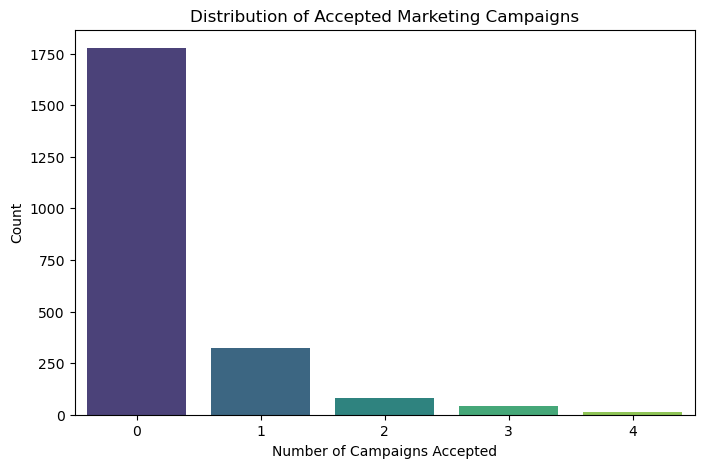

In [7]:
accepted_campaigns = ["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]
df["Total_Accepted_Campaigns"] = df[accepted_campaigns].sum(axis=1)

plt.figure(figsize=(8, 5))
sns.countplot(x=df["Total_Accepted_Campaigns"], palette="viridis")
plt.title("Distribution of Accepted Marketing Campaigns")
plt.xlabel("Number of Campaigns Accepted")
plt.ylabel("Count")
plt.savefig("accepted_campaigns_distribution.png", dpi=300, bbox_inches='tight')
plt.show()


<span style="font-size:20px; font-weight:bold; color:black;">Step 1.3: Average Spending Across Product Categories  </span>

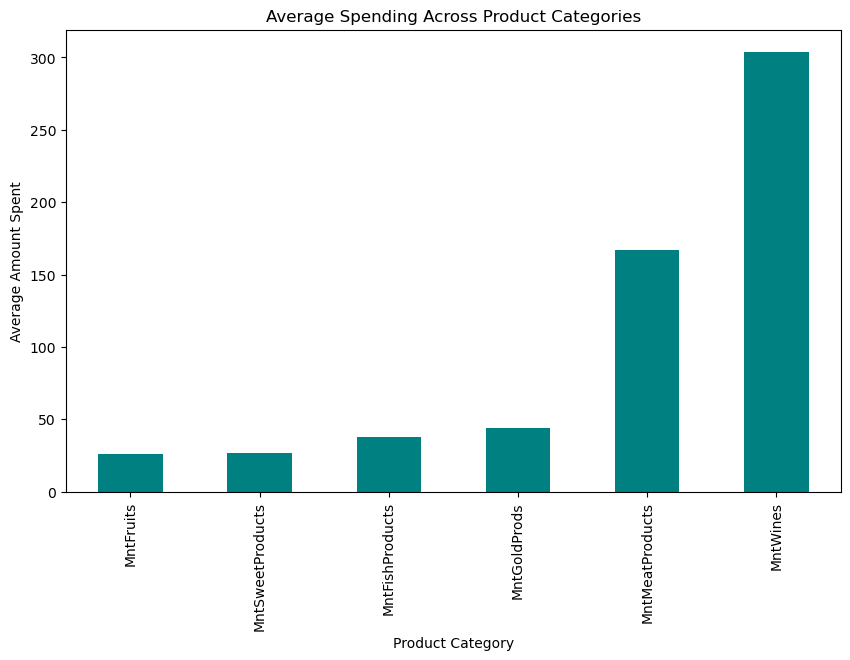

In [9]:
spending_features = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]

plt.figure(figsize=(10, 6))
df[spending_features].mean().sort_values().plot(kind="bar", color="teal")
plt.title("Average Spending Across Product Categories")
plt.xlabel("Product Category")
plt.ylabel("Average Amount Spent")
plt.savefig("spending_behavior.png", dpi=300, bbox_inches='tight')
plt.show()


<span style="font-size:20px; font-weight:bold; color:black;">Step 1.4: Family Size vs. Meat Product Spending  </span>

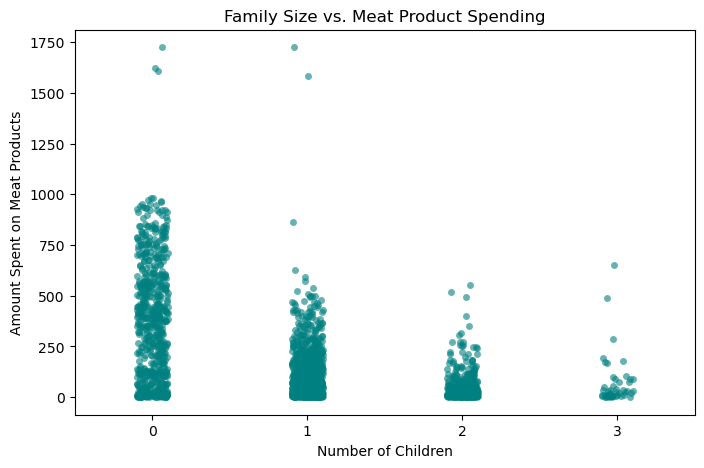

In [7]:
df["Total_Children"] = df["Kidhome"] + df["Teenhome"]
plt.figure(figsize=(8, 5))
sns.stripplot(x=df["Total_Children"], y=df["MntMeatProducts"], jitter=True, color="teal", alpha=0.6)
plt.title("Family Size vs. Meat Product Spending")
plt.xlabel("Number of Children")
plt.ylabel("Amount Spent on Meat Products")
plt.savefig("family_size_vs_spending_strip.png", dpi=300, bbox_inches='tight')
plt.show()

<span style="font-size:20px; font-weight:bold; color:black;">Step 1.5: Feature Correlation  </span>

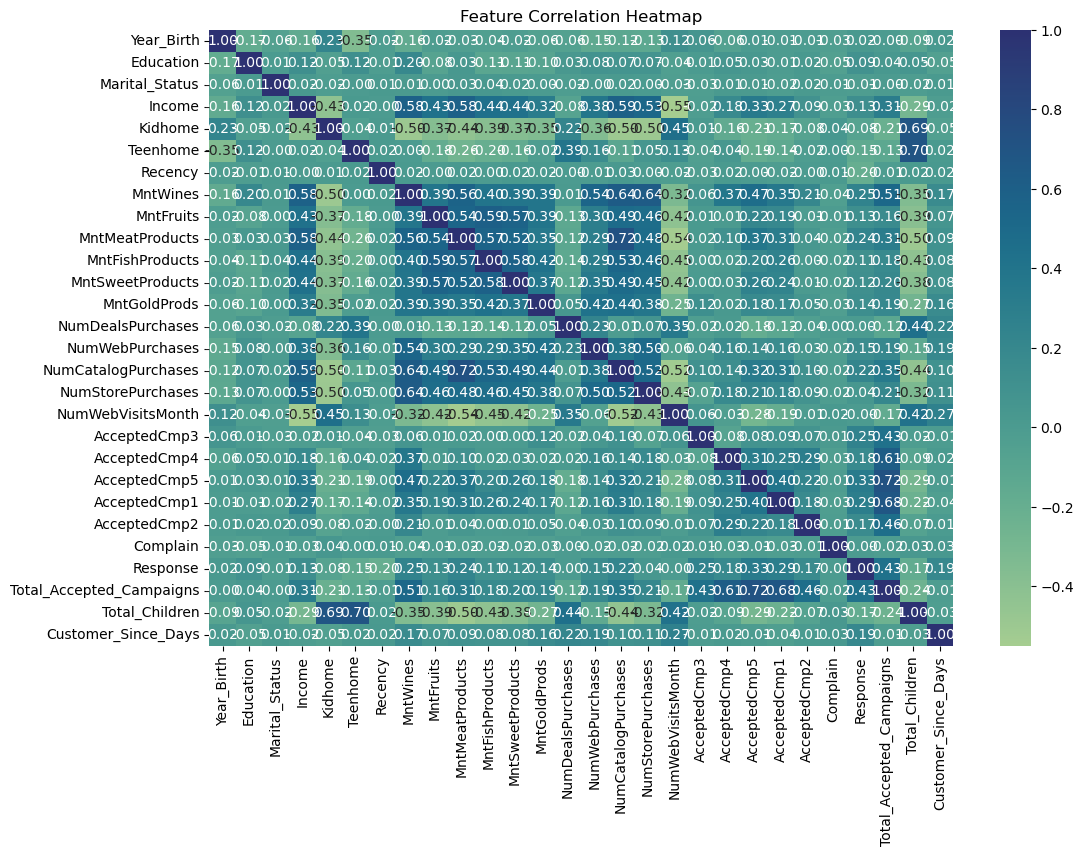

In [15]:
# Compute and Plot Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap="crest", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.savefig("market_correlation.png", dpi=300)
plt.show()



<span style="font-size:24px; font-weight:bold; color:black;">Step 2: Feature engineering & data preperation</span>

In [9]:
# Convert Dt_Customer to datetime and extract days since registration
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format="%d-%m-%Y")
df["Customer_Since_Days"] = (df["Dt_Customer"].max() - df["Dt_Customer"]).dt.days
df.drop(columns=["Dt_Customer"], inplace=True)

# Drop non-informative columns
df.drop(columns=["ID", "Z_CostContact", "Z_Revenue"], inplace=True)

# Encode categorical variables
label_encoders = {}
for col in ["Education", "Marital_Status"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

<span style="font-size:24px; font-weight:bold; color:black;">Step 3: Train-Test Split</span>

In [11]:
# Define Features and Target Variable
X = df.drop(columns=["AcceptedCmp1"])
y = df["AcceptedCmp1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<span style="font-size:24px; font-weight:bold; color:black;">Step 4: Modeling</span>

In [13]:
# Standardize Numerical Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



Model: Random Forest
Accuracy: 0.9464285714285714
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       419
           1       0.73      0.28      0.40        29

    accuracy                           0.95       448
   macro avg       0.84      0.63      0.69       448
weighted avg       0.94      0.95      0.93       448



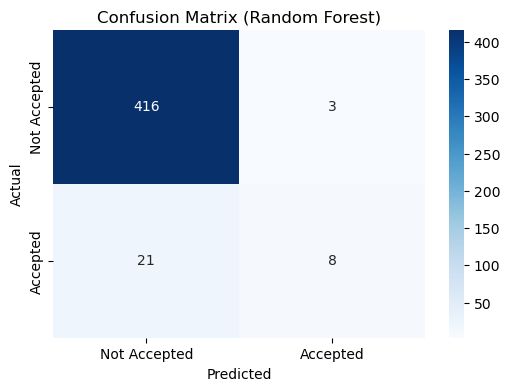


Model: Logistic Regression
Accuracy: 0.9397321428571429
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       419
           1       0.60      0.21      0.31        29

    accuracy                           0.94       448
   macro avg       0.77      0.60      0.64       448
weighted avg       0.92      0.94      0.93       448



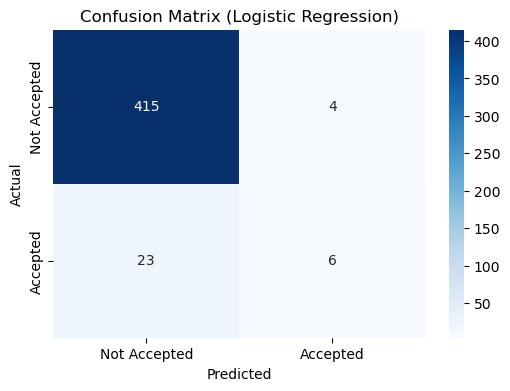


Model: SVM
Accuracy: 0.9508928571428571
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       419
           1       0.82      0.31      0.45        29

    accuracy                           0.95       448
   macro avg       0.89      0.65      0.71       448
weighted avg       0.95      0.95      0.94       448



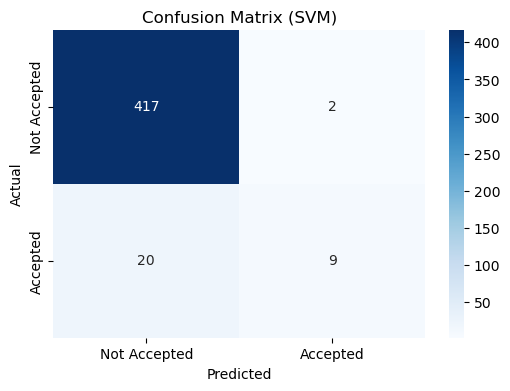


Model: Naive Bayes
Accuracy: 0.7008928571428571
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.68      0.81       419
           1       0.18      1.00      0.30        29

    accuracy                           0.70       448
   macro avg       0.59      0.84      0.56       448
weighted avg       0.95      0.70      0.78       448



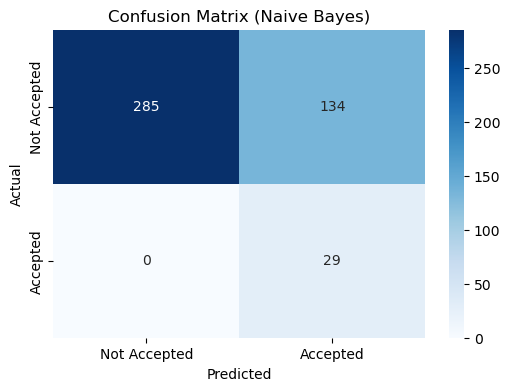


Model: Gradient Boosting
Accuracy: 0.9375
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       419
           1       0.53      0.31      0.39        29

    accuracy                           0.94       448
   macro avg       0.74      0.65      0.68       448
weighted avg       0.93      0.94      0.93       448



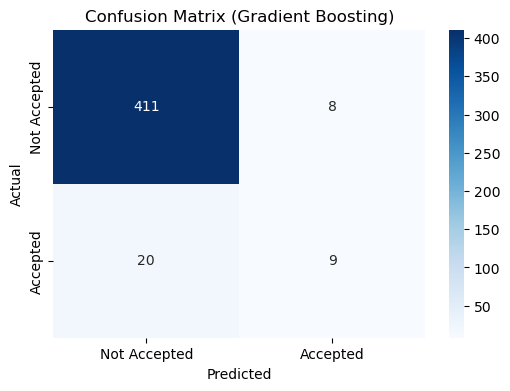

In [15]:
# Train Base Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier()
}

param_grids = {
    "Random Forest": {"n_estimators": [100, 200, 300], "max_depth": [None, 10, 20], "min_samples_split": [2, 5, 10]},
    "Logistic Regression": {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2"]},
    "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
    "Naive Bayes": {},
    "Gradient Boosting": {"n_estimators": [100, 200, 300], "learning_rate": [0.01, 0.1, 0.2], "max_depth": [3, 5, 7]}
}

best_models = {}

for name, model in models.items():
    if param_grids[name]:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy')
        grid_search.fit(X_train_scaled, y_train)
        best_models[name] = grid_search.best_estimator_
    else:
        model.fit(X_train_scaled, y_train)
        best_models[name] = model
    
    y_pred = best_models[name].predict(X_test_scaled)
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    
    # Visualize Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=["Not Accepted", "Accepted"], yticklabels=["Not Accepted", "Accepted"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({name})")
    plt.show()


<span style="font-size:24px; font-weight:bold; color:black;">Step 5: Optimization : SMOT </span>

In [17]:
# Apply SMOTE for Class Imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


<span style="font-size:24px; font-weight:bold; color:black;">Step 6: Model Re-Evaluation</span>

In [19]:
# Train Best Models on Balanced Data
for name, model in best_models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred_best = model.predict(X_test_scaled)
    print(f"\nOptimized Model: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred_best))
    print("Classification Report:\n", classification_report(y_test, y_pred_best))
  



Optimized Model: Random Forest
Accuracy: 0.9598214285714286
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       419
           1       0.79      0.52      0.62        29

    accuracy                           0.96       448
   macro avg       0.88      0.75      0.80       448
weighted avg       0.96      0.96      0.96       448


Optimized Model: Logistic Regression
Accuracy: 0.8526785714285714
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.85      0.91       419
           1       0.30      0.93      0.45        29

    accuracy                           0.85       448
   macro avg       0.65      0.89      0.68       448
weighted avg       0.95      0.85      0.88       448


Optimized Model: SVM
Accuracy: 0.8392857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0

<span style="font-size:20px; font-weight:bold; color:black;">Step 7.1: Confusion Matrix</span>

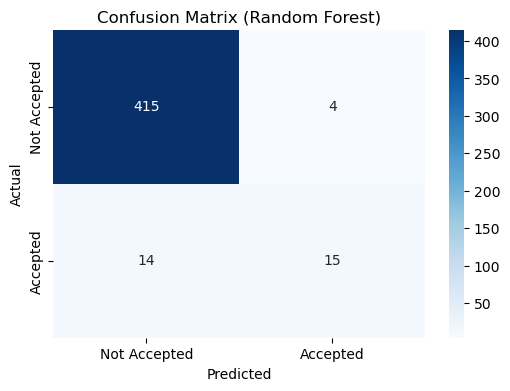

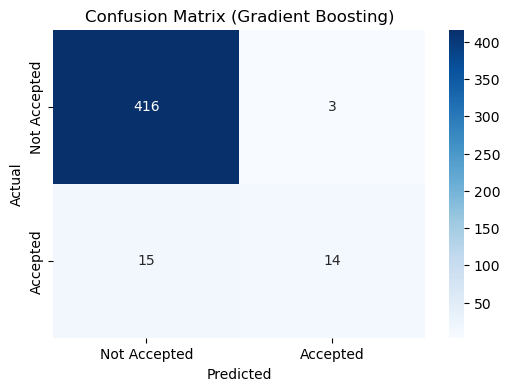

In [23]:
# Visualize Confusion Matrix for Best Models (Random Forest & Gradient Boosting)
best_models_to_plot = ["Random Forest", "Gradient Boosting"]

for name in best_models_to_plot:
    if name in best_models:
        y_pred_best = best_models[name].predict(X_test_scaled)

        # Compute Confusion Matrix
        conf_matrix = confusion_matrix(y_test, y_pred_best)

        # Plot Confusion Matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=["Not Accepted", "Accepted"], 
                    yticklabels=["Not Accepted", "Accepted"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix ({name})")

        # Save the confusion matrix with a unique filename
        filename = f"confusion_matrix_{name.replace(' ', '_').lower()}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()




<span style="font-size:20px; font-weight:bold; color:black;">Step 7.2: ROC Curve</span>

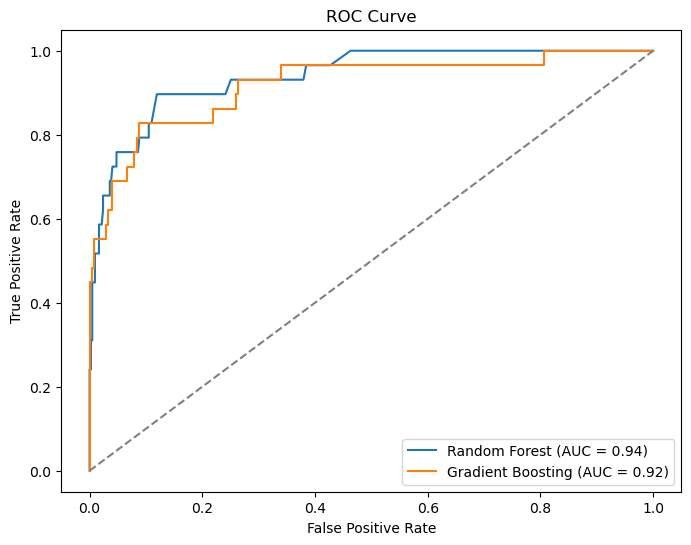

In [23]:
# ROC Curve for Random Forest & Gradient Boosting
plt.figure(figsize=(8, 6))

for name in ["Random Forest", "Gradient Boosting"]:
    if name in best_models:
        y_pred_prob = best_models[name].predict_proba(X_test_scaled)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig("roc.png")
plt.show()


<span style="font-size:20px; font-weight:bold; color:black;">Step 7.3: Residual Distribution</span>

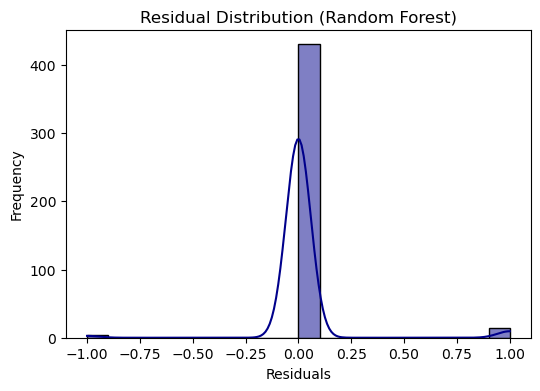

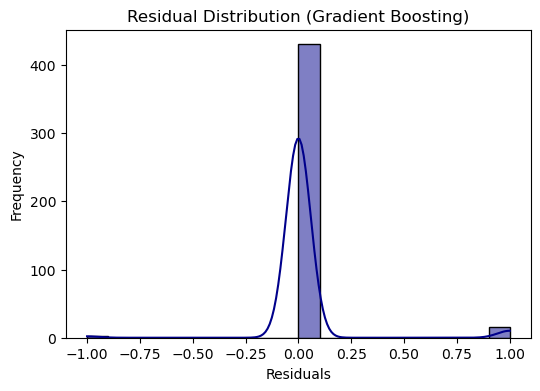

In [25]:
# Residual Distribution Plot for Random Forest & Gradient Boosting
for name in best_models_to_plot:
    if name in best_models:
        y_pred_best = best_models[name].predict(X_test_scaled)
        residuals = y_test - y_pred_best

        plt.figure(figsize=(6, 4))
        sns.histplot(residuals, bins=20, kde=True, color="darkblue")
        plt.xlabel("Residuals")
        plt.ylabel("Frequency")
        plt.title(f"Residual Distribution ({name})")
        plt.savefig("resi.png")
        plt.show()


<span style="font-size:24px; font-weight:bold; color:black;">Step 8: Deep analysis and Visualizations</span>

<span style="font-size:20px; font-weight:bold; color:black;">Step 8.1: Cumulative Gain Chart for Evaluating Model Performance</span>

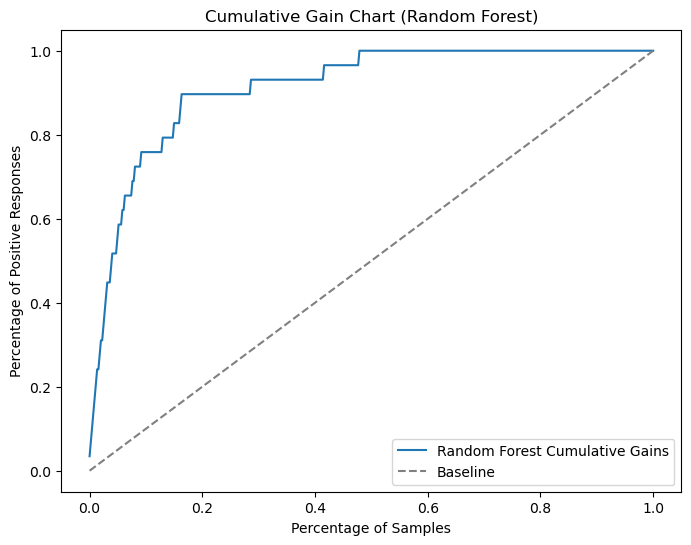

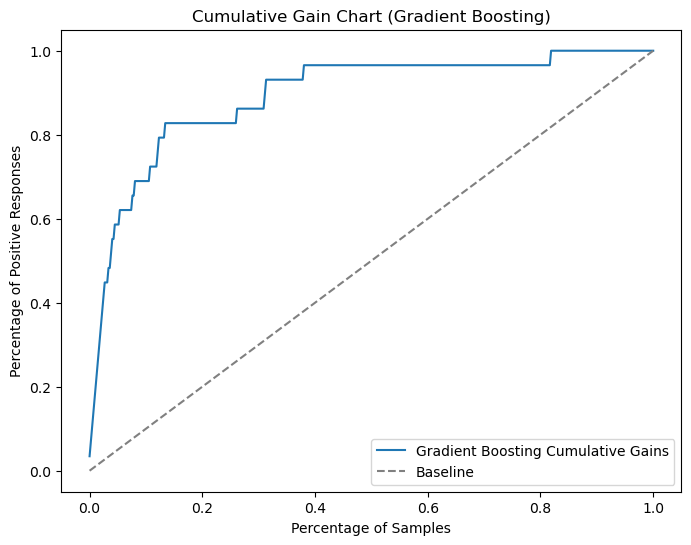

In [25]:
def plot_cumulative_gain(y_true, y_pred_proba, model_name):
    """
    Function to manually plot and save the Cumulative Gain Chart.
    """
    # Sort probabilities and actual values by probability scores in descending order
    sorted_indices = np.argsort(y_pred_proba)[::-1]
    y_true_sorted = np.array(y_true)[sorted_indices]

    # Cumulative sum of actual positives
    gains = np.cumsum(y_true_sorted) / sum(y_true_sorted)
    percents = np.linspace(0, 1, len(y_true_sorted))

    plt.figure(figsize=(8, 6))
    plt.plot(percents, gains, label=f'{model_name} Cumulative Gains')
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Baseline")
    plt.xlabel("Percentage of Samples")
    plt.ylabel("Percentage of Positive Responses")
    plt.title(f"Cumulative Gain Chart ({model_name})")
    plt.legend()

    # Save plot with a unique filename
    filename = f"cumulative_gain_{model_name.replace(' ', '_').lower()}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

   

# Apply function for Random Forest & Gradient Boosting
plot_cumulative_gain(y_test, best_models["Random Forest"].predict_proba(X_test_scaled)[:,1], "Random Forest")
plot_cumulative_gain(y_test, best_models["Gradient Boosting"].predict_proba(X_test_scaled)[:,1], "Gradient Boosting")


<span style="font-size:20px; font-weight:bold; color:black;">Step 8.2: Feature Importance</span>

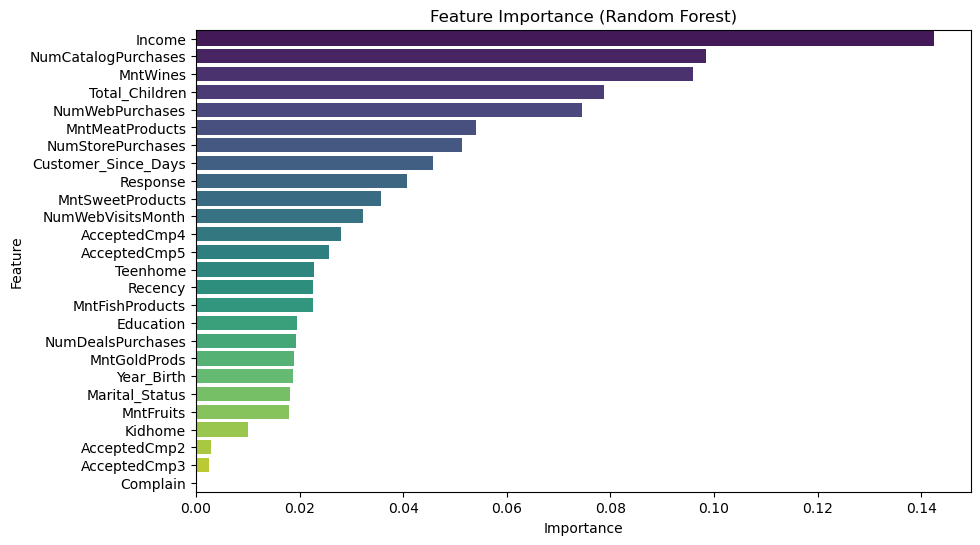

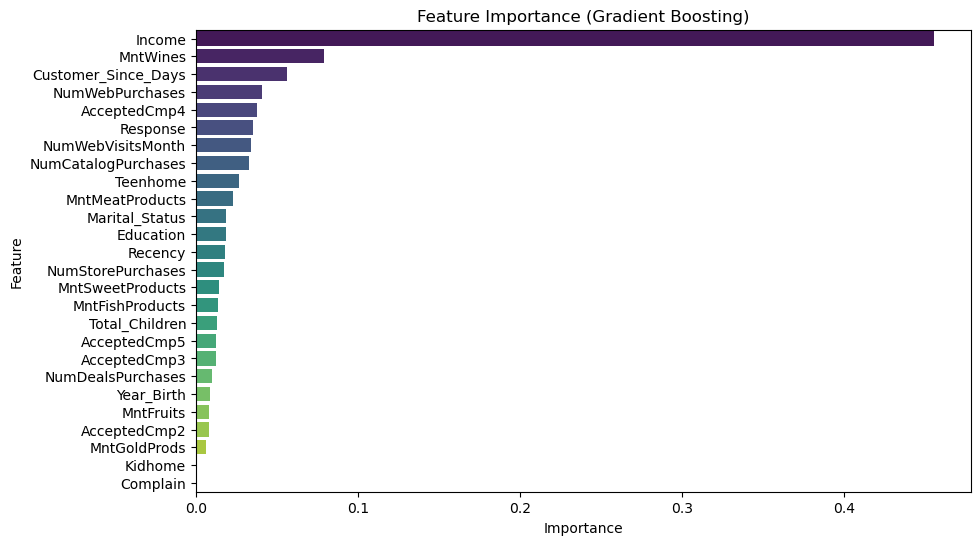

In [35]:
# Feature Importance for Random Forest & Gradient Boosting
importances = {}
for name in ["Random Forest", "Gradient Boosting"]:
    if name in best_models:
        importances[name] = best_models[name].feature_importances_

# Plot and Save Feature Importance
for name, importance in importances.items():
    plt.figure(figsize=(10, 6))
    feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": importance})
    feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

    sns.barplot(x="Importance", y="Feature", data=feature_importance_df, palette="viridis")
    plt.title(f"Feature Importance ({name})")
    
    # Save each plot separately with unique filenames
    filename = f"feature_importance_{name.replace(' ', '_').lower()}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


<span style="font-size:20px; font-weight:bold; color:black;">Step 8.3: Identifying High-Value Customers Based on Wine and Meat Spending</span>

High-value customers count: 330


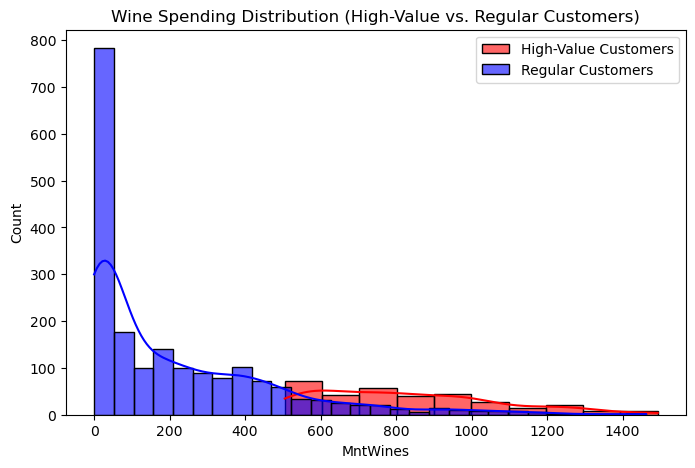

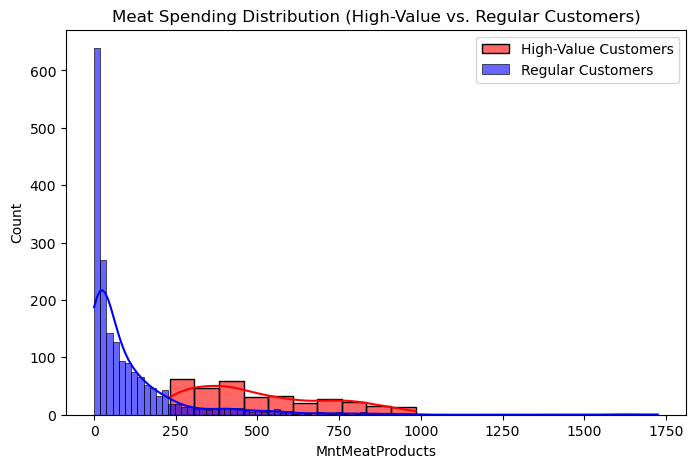

In [39]:
# Define high-value customer threshold
wine_threshold = df["MntWines"].quantile(0.75)
meat_threshold = df["MntMeatProducts"].quantile(0.75)

# Identify high-value customers
df["High_Value_Customer"] = ((df["MntWines"] >= wine_threshold) & (df["MntMeatProducts"] >= meat_threshold)).astype(int)

# Count high-value customers
print(f"High-value customers count: {df['High_Value_Customer'].sum()}")


plt.figure(figsize=(8, 5))
sns.histplot(df[df["High_Value_Customer"] == 1]["MntWines"], kde=True, color="red", label="High-Value Customers", alpha=0.6)
sns.histplot(df[df["High_Value_Customer"] == 0]["MntWines"], kde=True, color="blue", label="Regular Customers", alpha=0.6)
plt.title("Wine Spending Distribution (High-Value vs. Regular Customers)")
plt.legend()
plt.savefig("wine.png")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df[df["High_Value_Customer"] == 1]["MntMeatProducts"], kde=True, color="red", label="High-Value Customers", alpha=0.6)
sns.histplot(df[df["High_Value_Customer"] == 0]["MntMeatProducts"], kde=True, color="blue", label="Regular Customers", alpha=0.6)
plt.title("Meat Spending Distribution (High-Value vs. Regular Customers)")
plt.legend()
plt.savefig("meat.png")
plt.show()


<span style="font-size:20px; font-weight:bold; color:black;">Step 8.4: Analysis of Customer Demographics and Spending Behavior Based on Marketing Campaign Acceptance</span>

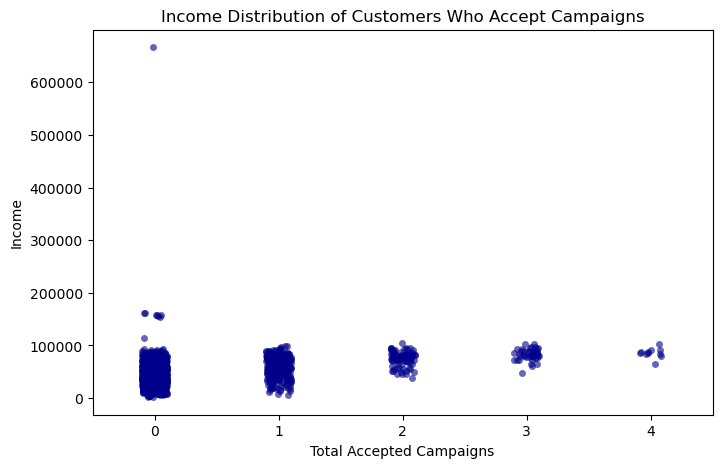

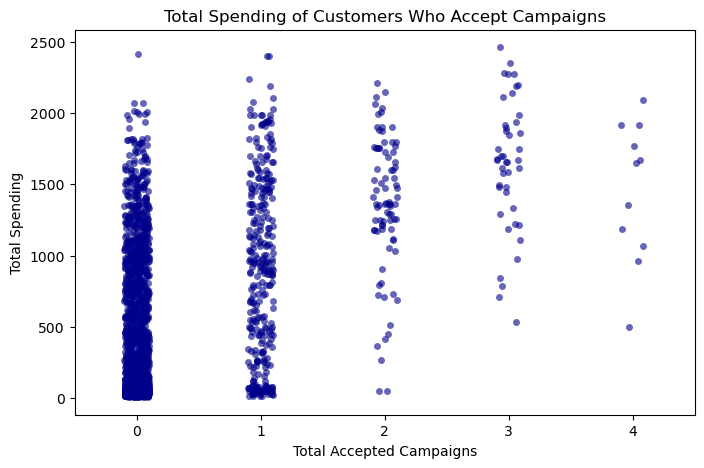

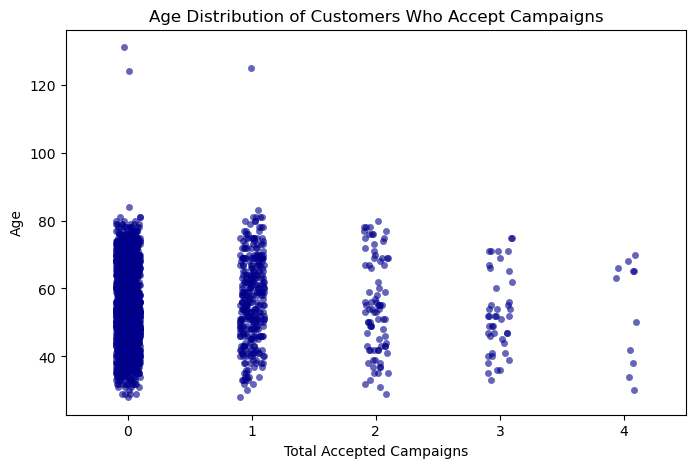

                                Age        Income  Total_Spending
Total_Accepted_Campaigns                                         
0                         55.005065  48877.448509      454.191896
1                         56.784615  59472.732308      890.236923
2                         54.626506  75158.108434     1363.590361
3                         52.522727  82877.272727     1644.886364
4                         53.727273  85861.636364     1462.909091


In [39]:
# Create Age Column from Year_Birth
df["Age"] = 2024 - df["Year_Birth"]  # Assuming the current year is 2024

# Create Total Spending Column
spending_columns = ["MntWines", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]
df["Total_Spending"] = df[spending_columns].sum(axis=1)

# Create a column for the total number of accepted campaigns
df["Total_Accepted_Campaigns"] = df[["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5"]].sum(axis=1)

# Set figure size and save the plots
plt.figure(figsize=(8, 5))
sns.stripplot(x=df["Total_Accepted_Campaigns"], y=df["Income"], color="darkblue", jitter=True, alpha=0.6)
plt.title("Income Distribution of Customers Who Accept Campaigns")
plt.xlabel("Total Accepted Campaigns")
plt.ylabel("Income")
plt.savefig("income_strip.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8, 5))
sns.stripplot(x=df["Total_Accepted_Campaigns"], y=df["Total_Spending"], color="darkblue", jitter=True, alpha=0.6)
plt.title("Total Spending of Customers Who Accept Campaigns")
plt.xlabel("Total Accepted Campaigns")
plt.ylabel("Total Spending")
plt.savefig("spending_strip.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure(figsize=(8, 5))
sns.stripplot(x=df["Total_Accepted_Campaigns"], y=df["Age"], color="darkblue", jitter=True, alpha=0.6)
plt.title("Age Distribution of Customers Who Accept Campaigns")
plt.xlabel("Total Accepted Campaigns")
plt.ylabel("Age")
plt.savefig("age_strip.png", dpi=300, bbox_inches="tight")
plt.show()

# Print summary statistics
summary_stats = df.groupby("Total_Accepted_Campaigns")[["Age", "Income", "Total_Spending"]].mean()
print(summary_stats)


<span style="font-size:20px; font-weight:bold; color:black;">Step 8.5: Customer Segmentation Using K-Means Clustering</span>

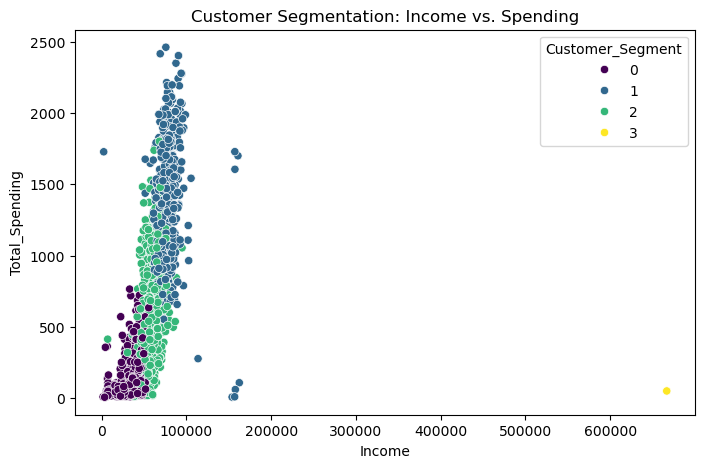

                         Income  Total_Spending  NumWebVisitsMonth
Customer_Segment                                                  
0                  33082.148594      121.533133           6.996988
1                  77715.788462     1342.314685           2.618881
2                  58037.478390      609.794337           5.120715
3                 666666.000000       48.000000           6.000000


In [41]:
# Select features for clustering
features = ["Income", "Total_Spending", "NumWebVisitsMonth"]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["Customer_Segment"] = kmeans.fit_predict(scaled_features)

# Visualize clusters
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["Income"], y=df["Total_Spending"], hue=df["Customer_Segment"], palette="viridis")
plt.title("Customer Segmentation: Income vs. Spending")
plt.savefig("cluster", dpi=300, bbox_inches="tight")
plt.show()

# Print segment averages
print(df.groupby("Customer_Segment")[["Income", "Total_Spending", "NumWebVisitsMonth"]].mean())


<span style="font-size:20px; font-weight:bold; color:black;">Step 8.6: Identifying High-Value Customers for Retargeting</span>

In [155]:
# Find high-value customers who rejected all campaigns
df["Rejected_All_Campaigns"] = (df["Total_Accepted_Campaigns"] == 0).astype(int)

# Find high-value customers who can be retargeted
retarget_customers = df[(df["High_Value_Customer"] == 1) & (df["Rejected_All_Campaigns"] == 1)]

print(f"Retargeting Potential Customers: {len(retarget_customers)}")

# Save retargeting data
retarget_customers.to_csv("retarget_high_value_customers.csv", index=False)


Retargeting Potential Customers: 157


<span style="font-size:20px; font-weight:bold; color:black;">Step 8.7: Identifying Web Visitors for Personalized Offers</span>

In [157]:
# Define customers with high web visits but low purchases
high_web_visits_threshold = df["NumWebVisitsMonth"].quantile(0.75)
low_web_purchases_threshold = df["NumWebPurchases"].quantile(0.25)

df["Potential_Conversion_Customer"] = ((df["NumWebVisitsMonth"] >= high_web_visits_threshold) & 
                                       (df["NumWebPurchases"] <= low_web_purchases_threshold)).astype(int)

print(f"Potential Conversion Customers: {df['Potential_Conversion_Customer'].sum()}")

# Save data for personalized offers
df[df["Potential_Conversion_Customer"] == 1].to_csv("web_visitors_to_target.csv", index=False)


Potential Conversion Customers: 352


<span style="font-size:20px; font-weight:bold; color:black;">Step 8.8: Spending Behavior of Families vs. Singles</span>

<Figure size 800x500 with 0 Axes>

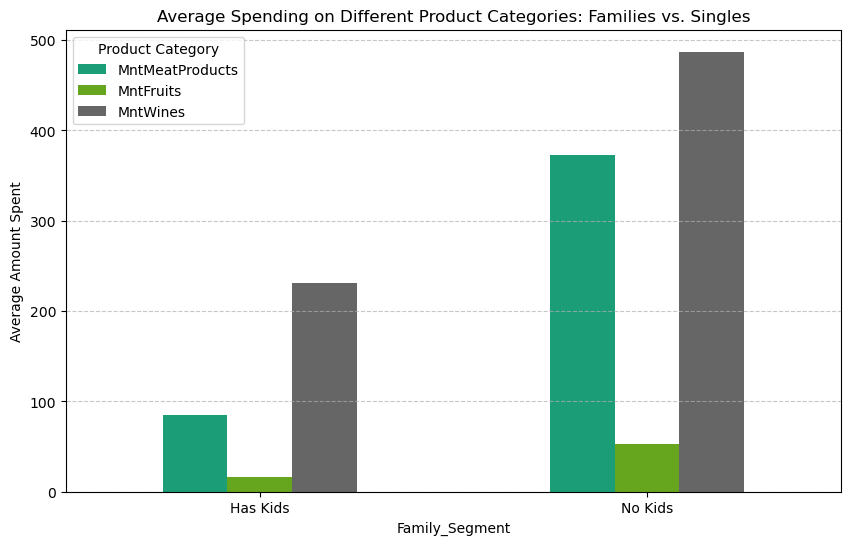

                MntMeatProducts  MntFruits    MntWines
Family_Segment                                        
Has Kids              85.045568  15.925718  230.908240
No Kids              372.609718  52.357367  487.305643


In [81]:
# Define family size
df["Total_Children"] = df["Kidhome"] + df["Teenhome"]
df["Family_Segment"] = df["Total_Children"].apply(lambda x: "No Kids" if x == 0 else "Has Kids")

# Calculate average spending per segment
family_spending = df.groupby("Family_Segment")[["MntMeatProducts", "MntFruits", "MntWines"]].mean()

# Plot the spending behavior as a bar chart
plt.figure(figsize=(8, 5))
family_spending.plot(kind="bar", figsize=(10, 6), colormap="Dark2")
plt.title("Average Spending on Different Product Categories: Families vs. Singles")
plt.ylabel("Average Amount Spent")
plt.xticks(rotation=0)  # Keep segment labels horizontal
plt.legend(title="Product Category")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.savefig("family_vs_singles_spending_bar.png", dpi=300, bbox_inches='tight')
plt.show()
print(df.groupby("Family_Segment")[["MntMeatProducts", "MntFruits", "MntWines"]].mean())
